In [1]:
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
from transformers import TrainingArguments
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer
from transformers import pipeline

import pandas as pd
import numpy as np
import re, os

from sklearn.model_selection import train_test_split

import torch
from huggingface_hub import notebook_login

notebook_login()

pd.set_option('display.max_colwidth', None)

In [2]:
block_size = 128
batch_size = 2
num_epochs = 3

In [3]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [4]:
with open("qa_arith.txt", encoding="utf-8") as f:
    train = f.read()

with open("qa_arith_test.txt", encoding="utf-8") as f:
    test = f.read()

train = train.split("\n\n")
test = test.split("\n\n")

In [5]:
train = pd.DataFrame({"text": train})
train["text"] = train["text"].str.replace("\n", " ").str.strip()
train = train[train["text"].str.len() <= 128]

test = pd.DataFrame({"text": test})
test["text"] = test["text"].str.replace("\n", " ").str.strip()
test = test[test["text"].str.len() <= 128]

df = pd.concat([train, test], axis=0)
train.head(2)

,text
0,"Q: Утром литовец покормил котика 2 раза, а после обеда еще 16 раз. Сколько всего раз он покормил котика? A: 18"
2,"Q: Что надо подставить вместо f, чтобы выражение f-58=73 стало верным? A: 131"


<AxesSubplot:>

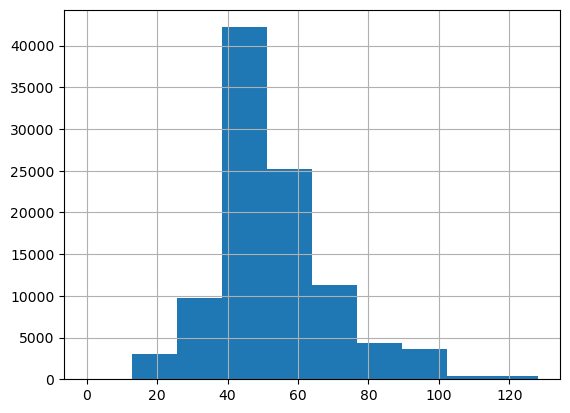

In [6]:
df["text"].str.len().hist()

In [7]:
ds = Dataset.from_pandas(df[["text"]]).train_test_split(test_size=0.2)

In [8]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128, padding="max_length", return_tensors="pt")

In [9]:
tokenized_ds = ds.map(
    preprocess_function,
    batched=True,
    remove_columns=ds["train"].column_names,
)

Map:   0%|          | 0/80128 [00:00<?, ? examples/s]

Map:   0%|          | 0/20033 [00:00<?, ? examples/s]

In [10]:
def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [11]:
ds = tokenized_ds.map(group_texts, batched=True)

Map:   0%|          | 0/80128 [00:00<?, ? examples/s]

Map:   0%|          | 0/20033 [00:00<?, ? examples/s]

In [12]:
model = AutoModelForMaskedLM.from_pretrained("sberbank-ai/ruRoberta-large")

In [13]:
logging_steps = len(ds["train"]) // batch_size
model_name = "ruRoberta-large"

args = TrainingArguments(
    output_dir=f"{model_name}-arithmetics",
    overwrite_output_dir=False,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_epochs,
    gradient_accumulation_steps=4,
    logging_steps=logging_steps,
    push_to_hub=False,
    report_to="none",
)

In [14]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=data_collator,
)

In [15]:
trainer.train()

***** Running training *****
  Num examples = 80128
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 30048
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,nan
2,No log,nan
3,No log,nan


Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-500
Configuration saved in ruRoberta-large-arithmetics\checkpoint-500\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-500\pytorch_model.bin
Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-1000
Configuration saved in ruRoberta-large-arithmetics\checkpoint-1000\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-1000\pytorch_model.bin
Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-1500
Configuration saved in ruRoberta-large-arithmetics\checkpoint-1500\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-1500\pytorch_model.bin
Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-2000
Configuration saved in ruRoberta-large-arithmetics\checkpoint-2000\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-2000\pytorch_model.bin
Deleting older checkpoint [ruRoberta-large-arithmetics\checkpoi

Configuration saved in ruRoberta-large-arithmetics\checkpoint-13000\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-13000\pytorch_model.bin
Deleting older checkpoint [ruRoberta-large-arithmetics\checkpoint-11500] due to args.save_total_limit
Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-13500
Configuration saved in ruRoberta-large-arithmetics\checkpoint-13500\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-13500\pytorch_model.bin
Deleting older checkpoint [ruRoberta-large-arithmetics\checkpoint-12000] due to args.save_total_limit
Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-14000
Configuration saved in ruRoberta-large-arithmetics\checkpoint-14000\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-14000\pytorch_model.bin
Deleting older checkpoint [ruRoberta-large-arithmetics\checkpoint-12500] due to args.save_total_limit
Saving model checkpoint to ruRoberta-large-arithmeti

Configuration saved in ruRoberta-large-arithmetics\checkpoint-25000\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-25000\pytorch_model.bin
Deleting older checkpoint [ruRoberta-large-arithmetics\checkpoint-23500] due to args.save_total_limit
Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-25500
Configuration saved in ruRoberta-large-arithmetics\checkpoint-25500\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-25500\pytorch_model.bin
Deleting older checkpoint [ruRoberta-large-arithmetics\checkpoint-24000] due to args.save_total_limit
Saving model checkpoint to ruRoberta-large-arithmetics\checkpoint-26000
Configuration saved in ruRoberta-large-arithmetics\checkpoint-26000\config.json
Model weights saved in ruRoberta-large-arithmetics\checkpoint-26000\pytorch_model.bin
Deleting older checkpoint [ruRoberta-large-arithmetics\checkpoint-24500] due to args.save_total_limit
Saving model checkpoint to ruRoberta-large-arithmeti

TrainOutput(global_step=30048, training_loss=0.6603714005507854, metrics={'train_runtime': 21861.9022, 'train_samples_per_second': 10.996, 'train_steps_per_second': 1.374, 'total_flos': 5.601462650988134e+16, 'train_loss': 0.6603714005507854, 'epoch': 3.0})

In [16]:
model.push_to_hub(f"{model_name}-arithmetics")
tokenizer.push_to_hub(f"{model_name}-arithmetics")

Configuration saved in ruRoberta-large-arithmetics\config.json
Model weights saved in ruRoberta-large-arithmetics\pytorch_model.bin
Uploading the following files to pankratozzi/ruRoberta-large-arithmetics: config.json,pytorch_model.bin
tokenizer config file saved in ruRoberta-large-arithmetics\tokenizer_config.json
Special tokens file saved in ruRoberta-large-arithmetics\special_tokens_map.json
Uploading the following files to pankratozzi/ruRoberta-large-arithmetics: merges.txt,special_tokens_map.json,tokenizer.json,tokenizer_config.json,vocab.json


In [18]:
mask_filler = pipeline("fill-mask", f"{model_name}-arithmetics")

loading configuration file ruRoberta-large-arithmetics\config.json
Model config RobertaConfig {
  "_name_or_path": "ruRoberta-large-arithmetics",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.22.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading configuration file ruRoberta-large-arithmetics\config.json
Model config RobertaConfig {
  "_name_or_path": "ruRoberta-large-arithmetics",
  "architectures": [
    "RobertaFor

In [19]:
text = "Q: Сколько будет, если к 35 прибавить 15? A: <mask>"

mask_filler(text, top_k=3)

[{'score': 0.3079615831375122,
  'token': 4996,
  'token_str': ' 50',
  'sequence': 'Q: Сколько будет, если к 35 прибавить 15? A: 50'},
 {'score': 0.23250150680541992,
  'token': 14165,
  'token_str': ' 48',
  'sequence': 'Q: Сколько будет, если к 35 прибавить 15? A: 48'},
 {'score': 0.1253935843706131,
  'token': 16951,
  'token_str': ' 49',
  'sequence': 'Q: Сколько будет, если к 35 прибавить 15? A: 49'}]

In [20]:
text = "Q: Сколько будет, если к 30 прибавить 15? A: <mask>"

mask_filler(text, top_k=3)

[{'score': 0.8001770973205566,
  'token': 9634,
  'token_str': ' 45',
  'sequence': 'Q: Сколько будет, если к 30 прибавить 15? A: 45'},
 {'score': 0.07102435827255249,
  'token': 4996,
  'token_str': ' 50',
  'sequence': 'Q: Сколько будет, если к 30 прибавить 15? A: 50'},
 {'score': 0.038213614374399185,
  'token': 18972,
  'token_str': ' 43',
  'sequence': 'Q: Сколько будет, если к 30 прибавить 15? A: 43'}]

In [21]:
text = "Q: Сколько будет, если из 35 вычесть 15? A: <mask>"

mask_filler(text, top_k=3)

[{'score': 0.8063234686851501,
  'token': 889,
  'token_str': ' 20',
  'sequence': 'Q: Сколько будет, если из 35 вычесть 15? A: 20'},
 {'score': 0.0744723379611969,
  'token': 2359,
  'token_str': ' 15',
  'sequence': 'Q: Сколько будет, если из 35 вычесть 15? A: 15'},
 {'score': 0.021975386887788773,
  'token': 1675,
  'token_str': ' 18',
  'sequence': 'Q: Сколько будет, если из 35 вычесть 15? A: 18'}]

In [25]:
out = mask_filler(text, top_k=3)
max(out, key=lambda x: x["score"])["sequence"]

'Q: Сколько будет, если из 35 вычесть 15? A: 20'